<a href="https://colab.research.google.com/github/HBaldwin3/CaseStudy_FSH_LaoPDR/blob/main/Validation_10_28_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up workspace

##Imports

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from osgeo import gdal  
from sklearn.metrics import r2_score
import seaborn as sns; sns.set(color_codes=True)
import imageio
from scipy.interpolate import *
from scipy.stats import *
from scipy import ndimage, misc
import matplotlib.lines as lines
import glob
import math
import statistics
import sklearn

##Connect to google drive

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


##Navigate to Backscatter Directory

In [ ]:
cd /content/notebooks/ASF_RTC_Backscatter_Investigation/

/content/mnt/My Drive/Colab Notebooks/ASF_RTC_Backscatter_Investigation


In [ ]:
%ls

asf_EstimatedHeight_testing.tif  EstimatedHeight_asf_v17.tif
asf_resamp_v4.tif                LiDAR_testing.tif
asf_testing_v2.tif               LiDAR_training.tif
asf_training_v2.tif


#Bring in datasets

##Testing LiDAR

In [ ]:
lidar_testing = "LiDAR_testing.tif"

In [ ]:
lidar = gdal.Open(lidar_testing)
xlidar = lidar.ReadAsArray()

##InSAR Output

Let's test the low coherence removed and no low coherence for the 2009 InSAR output (that was created using the FNF mask and lidar training data that had already been resampled to 6 ha). 

In [ ]:
insar_height_2009_low_coh_inc = "testing_2009_low_coh_inc_resamp6.tif"

In [ ]:
insar_2009_low = gdal.Open(insar_height_2009_low_coh_inc)
y_2009_low = insar_2009_low.ReadAsArray()

In [ ]:
insar_height_2009_low_coh_exc = "testing_2009_no_low_coh_resamp6.tif"

In [ ]:
insar_2009_no = gdal.Open(insar_height_2009_low_coh_exc)
y_2009_no = insar_2009_no.ReadAsArray()

#Clean input datasets

In [ ]:
print(xlidar.shape)
print(y_2009_low.shape)
print(y_2009_no.shape)

(86, 139)
(86, 139)
(86, 139)


In [ ]:
print(xlidar)
print(y_2009_low)
print(y_2009_no)

[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38  9.9106970e+00 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 ...
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]]
[[65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535    13 65535]
 ...
 [   19 65535 65535 ... 65535    16 65535]
 [65535 65535 65535 ... 65535 65535 65535]
 [65535 65535 65535 ... 65535 65535 65535]]
[[-2147483647 -2147483647 -2147483647 ... -2147483647 -2147483647
  -2147483647]
 [-2147483647 -2147483647 -2147483647 ... -2147483647 -

Squash 2D to 1D

In [ ]:
x_rav = np.array(xlidar).ravel()
print("x_ravel", x_rav.shape) 

y_rav2009_no = np.array(y_2009_no).ravel()
print("2009 no low coherence ravel", y_rav2009_no.shape) 

y_rav2009_low = np.array(y_2009_low).ravel()
print("2009 low coherence included ravel", y_rav2009_low.shape) 

x_ravel (11954,)
2009 no low coherence ravel (11954,)
2009 low coherence included ravel (11954,)


add in NaNs

In [ ]:
x_nan = np.where(x_rav<0, np.NaN, x_rav)

y_nan2009_no = np.where(y_rav2009_no<0, np.NaN, y_rav2009_no)
y_nan2009_low = np.where(y_rav2009_low<0, np.NaN, y_rav2009_low)

print(x_nan)
print(y_nan2009_no)
print(y_nan2009_low)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
[65535. 65535. 65535. ... 65535. 65535. 65535.]


and to get rid of additional nodata values...

In [ ]:
y_nan2009_low_2 = np.where(y_nan2009_low>65534, np.NaN, y_nan2009_low)

print(y_nan2009_low_2)

[nan nan nan ... nan nan nan]


Ignore nan values in both inputs by creating a mask called "bad" (potentially add inf into this). Then compress the ravelled x and y data with the 'bad' mask to create two new datasets xnew and ynew that should match in size and shape (1D).

In [ ]:
bad_no = ~np.logical_or(np.isnan(y_nan2009_no), np.isnan(x_nan))
bad_low = ~np.logical_or(np.isnan(y_nan2009_low_2), np.isnan(x_nan))

In [ ]:
xnew2009_no = np.compress(bad_no, x_nan)
ynew2009_no = np.compress(bad_no, y_nan2009_no)

xnew2009_low = np.compress(bad_low, x_nan)
ynew2009_low = np.compress(bad_low, y_nan2009_low_2)

In [ ]:
print(ynew2009_low)
print(ynew2009_no)

[ 8. 19. 19. ... 17. 19. 19.]
[ 8. 14. 17. 10. 11. 10. 16.  7. 12. 16.  9. 14. 11. 13. 11. 11. 16. 12.
 12. 14. 14. 13. 15. 13. 16. 13. 14. 15. 14. 14. 12. 13. 11. 14. 16. 17.
 14. 12. 12.  9. 10. 13. 13. 14. 16. 13.  8. 13. 16. 16. 15. 13. 14. 10.
 11. 14. 13. 14. 13. 12. 13. 13. 15.  6. 15.  8.  7. 10. 10.  8. 10. 16.
  8. 13.  8.  9. 12.  9. 16. 12. 12. 11.  9.  9. 11.  4. 12. 17. 16. 11.
 15.  9. 10.  9. 12.  8. 11. 12. 14. 14. 11. 13. 16. 13. 13. 15. 16. 15.
 12. 18. 12.  8. 14. 15. 11. 15. 14. 14. 12. 12. 12. 15. 15. 13. 17. 12.
 13. 10. 12.  4. 18. 12. 10. 16. 16. 14. 14. 11.  7. 13.  4. 14. 16. 15.
 16.  7. 11. 14. 12. 11. 10.  6. 12. 10. 15. 13. 13. 12. 10. 13. 18. 13.
  8. 10.  8. 10. 15.  9. 13. 11. 11. 12.  9. 14.  4.  7.  9. 11.  8. 15.
 12. 14. 13. 12. 15. 16. 17. 13. 11. 10. 12. 11.  5. 10. 13.  7. 17. 16.
 12. 13. 14. 12. 12. 13. 11. 10. 14.  7. 14. 10. 12. 12. 16. 14. 15. 15.
 13. 14. 13. 11.  5.  7. 10. 10. 12.  9. 12. 12. 14. 13. 14.  9. 13. 11.
 13. 13. 10.  6.  8. 

In [ ]:
print(ynew2009_no.shape)
print(ynew2009_low.shape)

(801,)
(1178,)


#Graph and Calculate Metrics

Used 22 as the ylim for low incoherence included, 25 ylim for all of the other graphs

First computing for no low coherence

best fit line:
y = 6.22 + 0.34x


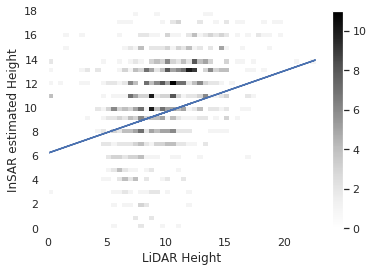

bias 0.8421566460500198
numpy R2 0.13458067892570727
stats R value 0.3668523939211891
stats R2 0.13458067892570733
RMSE  3.9344127499445376
standard deviation of InSAR height 3.5394305564835973


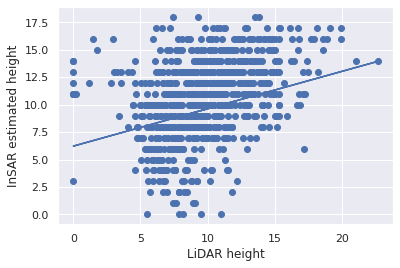

In [ ]:
#line of best fit
#https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denom = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denom
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

a, b = best_fit(ynew2009_no, xnew2009_no)
yfit = [a + b * xi for xi in xnew2009_no]

#Density plot: https://python-graph-gallery.com/83-basic-2d-histograms-with-matplotlib/
plt.plot(xnew2009_no, yfit)
plt.hist2d(xnew2009_no, ynew2009_no, bins=(50, 50), cmap=plt.cm.Greys)
plt.ylim(top=18)
plt.colorbar()

plt.xlabel('LiDAR Height')
plt.ylabel('InSAR estimated Height')
#plt.legend()
plt.show()

#although not actually predicting anything here...
actual = xnew2009_no
predicted = ynew2009_no

#calculate bias
#confirm this process
bias = statistics.mean(predicted-actual)
print ("bias", bias)

correlation_matrix = np.corrcoef(actual, predicted)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("numpy R2", r_squared)

slope, intercept, r_value, p_value, std_err = stats.linregress(actual, predicted)
print ("stats R value", r_value)
statsR2 = r_value*r_value
print("stats R2", statsR2)

mse = sklearn.metrics.mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)
print ("RMSE ", rmse)

stdev = statistics.stdev(ynew2009_no)
print("standard deviation of InSAR height", stdev)

fig = plt.figure()
plt.scatter(xnew2009_no, ynew2009_no) #, c=colors, alpha=0.5
plt.plot( xnew2009_no, yfit, figure=fig )
plt.xlabel('LiDAR height')
plt.ylabel('InSAR estimated height')
plt.show()

And now we will repeat for the low coherence (less than 0.2) included

best fit line:
y = 6.53 + 0.29x


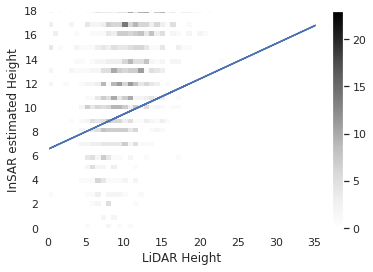

bias 2.954462571831733
numpy R2 0.13121904078572716
stats R value 0.3622416883597568
stats R2 0.13121904078572716
RMSE  5.634251613043476
standard deviation of InSAR height 4.6475250328717355


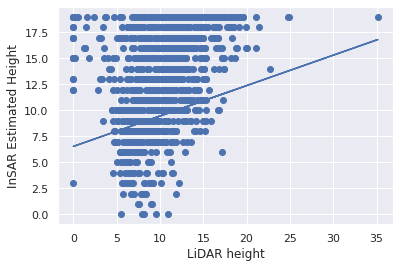

In [ ]:
#line of best fit
#https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denom = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denom
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

a, b = best_fit(ynew2009_low, xnew2009_low)
yfit = [a + b * xi for xi in xnew2009_low]

#Density plot: https://python-graph-gallery.com/83-basic-2d-histograms-with-matplotlib/
plt.plot(xnew2009_low, yfit)
plt.hist2d(xnew2009_low, ynew2009_low, bins=(50, 50), cmap=plt.cm.Greys)
plt.ylim(top=18)
plt.colorbar()

plt.xlabel('LiDAR Height')
plt.ylabel('InSAR estimated Height')
#plt.legend()
plt.show()

#although not actually predicting anything here...
actual = xnew2009_low
predicted = ynew2009_low

#calculate bias
#confirm this process
bias = statistics.mean(predicted-actual)
print ("bias", bias)

correlation_matrix = np.corrcoef(actual, predicted)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("numpy R2", r_squared)

slope, intercept, r_value, p_value, std_err = stats.linregress(actual, predicted)
print ("stats R value", r_value)
statsR2 = r_value*r_value
print("stats R2", statsR2)

mse = sklearn.metrics.mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)
print ("RMSE ", rmse)

stdev = statistics.stdev(ynew2009_low)
print("standard deviation of InSAR height", stdev)

fig = plt.figure()
plt.scatter(xnew2009_low, ynew2009_low) #, c=colors, alpha=0.5
plt.plot( xnew2009_low, yfit, figure=fig )
plt.xlabel('LiDAR height')
plt.ylabel('InSAR Estimated Height')
plt.show()

##Backscatter Product

We will compare the 6 ha produced backscatter product based on various colab coefficients. 

In [ ]:
%ls

So bring in our two datasets...

In [ ]:
lidar_testing = "LiDAR_testing.tif"

In [ ]:
lidar = gdal.Open(lidar_testing)
xlidar = lidar.ReadAsArray()

In [ ]:
backscatter = "asf_EstimatedHeight_testing.tif"

In [ ]:
bs_FSH = gdal.Open(backscatter)
bs = bs_FSH.ReadAsArray()

Check them...

In [ ]:
print(bs.shape)
print(xlidar.shape)

(86, 139)
(86, 139)


In [ ]:
print(bs)

[[-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38  1.4705623e+01 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 ...
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]
 [-3.4028235e+38 -3.4028235e+38 -3.4028235e+38 ... -3.4028235e+38
  -3.4028235e+38 -3.4028235e+38]]


Clean them up...

In [ ]:
x_rav = np.array(xlidar).ravel()
print("x_ravel", x_rav.shape) 

y_bs = np.array(bs).ravel()
print("Backscatter estimated height ravel", y_bs.shape) 

x_ravel (11954,)
Backscatter estimated height ravel (11954,)


Add in NaNs

In [ ]:
x_nan = np.where(x_rav<0, np.NaN, x_rav)

y_nan = np.where(y_bs<0, np.NaN, y_bs)

print(y_nan)
print(x_nan)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


In [ ]:
bad_bs = ~np.logical_or(np.isnan(x_nan), np.isnan(y_nan))

In [ ]:
xnew = np.compress(bad_bs, x_nan)
ynew = np.compress(bad_bs, y_nan)

In [ ]:
print(xnew)
print(ynew)

[ 9.910697  5.79     15.283643 ... 12.094468 16.136358 18.390541]
[14.705623  10.5033655  4.953572  ... 11.145048  10.151356  14.87663  ]


best fit line:
y = 2.77 + 0.55x


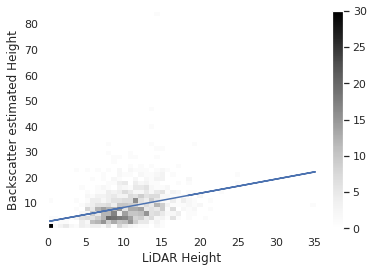

bias -1.8368144
numpy R2 0.12347685398047098
stats R value 0.3513927346722908
stats R2 0.12347685398047098
RMSE  6.344058174953731


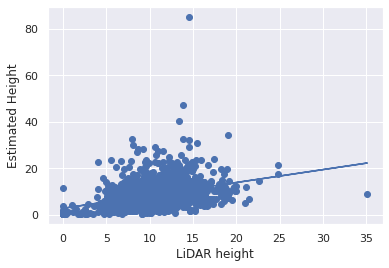

In [ ]:
#line of best fit
#https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denom = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denom
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

a, b = best_fit(xnew, ynew)
yfit = [a + b * xi for xi in xnew]

#Density plot: https://python-graph-gallery.com/83-basic-2d-histograms-with-matplotlib/
plt.plot(xnew, yfit)
plt.hist2d(xnew, ynew, bins=(50, 50), cmap=plt.cm.Greys)
#plt.ylim(top=80)
plt.colorbar()

plt.xlabel('LiDAR Height')
plt.ylabel('Backscatter estimated Height')
#plt.legend()
plt.show()

#although not actually predicting anything here...
actual = xnew
predicted = ynew

#calculate bias
#confirm this process
bias = statistics.mean(predicted-actual)
print ("bias", bias)

correlation_matrix = np.corrcoef(actual, predicted)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("numpy R2", r_squared)

slope, intercept, r_value, p_value, std_err = stats.linregress(actual, predicted)
print ("stats R value", r_value)
statsR2 = r_value*r_value
print("stats R2", statsR2)

mse = sklearn.metrics.mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)
print ("RMSE ", rmse)

#stdev = statistics.stdev(ynew)
#print("standard deviation of InSAR height", stdev)

fig = plt.figure()
plt.scatter(xnew, ynew) #, c=colors, alpha=0.5
plt.plot( xnew, yfit, figure=fig )
plt.xlabel('LiDAR height')
plt.ylabel('Estimated Height')
plt.show()

##Fusion Product

We will validate the fusion product against other raster products (GLAD 2019, potentially add GLAD 2010). 

The point validation (GEDI, hdom) was completed in ArcMap and Excel. 

In [ ]:
%ls

In [ ]:
glad_testing = "GLAD_2019_setnull.tif"

In [ ]:
glad = gdal.Open(glad_testing)
xGLAD = glad.ReadAsArray()

In [ ]:
fusion = "Fusion_v1_extract.tif"

In [ ]:
fusion_FSH = gdal.Open(fusion)
fs = fusion_FSH.ReadAsArray()

Check to make sure they are the same

In [ ]:
print(xGLAD.shape)
print(fs.shape)

(401, 404)
(401, 404)


In [ ]:
x_rav = np.array(xGLAD).ravel()
print("GLAD", x_rav.shape) 

y_rav = np.array(fs).ravel()
print("Fusion", y_rav.shape) 

GLAD (162004,)
Fusion (162004,)


In [ ]:
x_nan = np.where(x_rav<0, np.NaN, x_rav)

y_nan = np.where(y_rav<0, np.NaN, y_rav)

print(y_nan)
print(x_nan)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


In [ ]:
bad_bs = ~np.logical_or(np.isnan(x_nan), np.isnan(y_nan))

In [ ]:
xnew = np.compress(bad_bs, x_nan)
ynew = np.compress(bad_bs, y_nan)

In [ ]:
print(xnew)
print(ynew)

[23. 28. 23. ...  0.  0. 17.]
[19.       14.        9.781096 ... 13.       19.       11.      ]


best fit line:
y = 6.59 + 0.44x


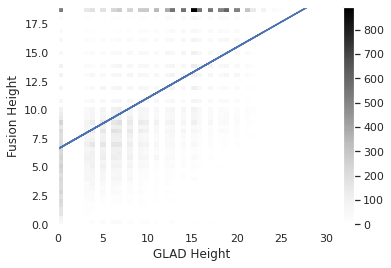

bias 1.5117245690620789
numpy R2 0.25190526936992613
stats R value 0.5019016530854686
stats R2 0.25190526936992613
RMSE  6.123063531529451


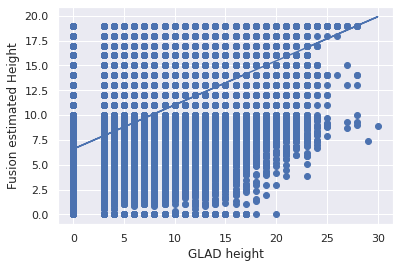

In [ ]:
#line of best fit
#https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denom = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denom
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

a, b = best_fit(xnew, ynew)
yfit = [a + b * xi for xi in xnew]

#Density plot: https://python-graph-gallery.com/83-basic-2d-histograms-with-matplotlib/
plt.plot(xnew, yfit)
plt.hist2d(xnew, ynew, bins=(50, 50), cmap=plt.cm.Greys)
#plt.ylim(top=80)
plt.colorbar()

plt.xlabel('GLAD Height')
plt.ylabel('Fusion Height')
#plt.legend()
plt.show()

#although not actually predicting anything here...
actual = xnew
predicted = ynew

#calculate bias
#confirm this process
bias = statistics.mean(predicted-actual)
print ("bias", bias)

correlation_matrix = np.corrcoef(actual, predicted)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("numpy R2", r_squared)

slope, intercept, r_value, p_value, std_err = stats.linregress(actual, predicted)
print ("stats R value", r_value)
statsR2 = r_value*r_value
print("stats R2", statsR2)

mse = sklearn.metrics.mean_squared_error(actual, predicted)
rmse = math.sqrt(mse)
print ("RMSE ", rmse)

#stdev = statistics.stdev(ynew)
#print("standard deviation of InSAR height", stdev)

fig = plt.figure()
plt.scatter(xnew, ynew) #, c=colors, alpha=0.5
plt.plot( xnew, yfit, figure=fig )
plt.xlabel('GLAD height')
plt.ylabel('Fusion estimated Height')
plt.show()

##Pairplot

https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot

Full pandas dataframe needs to be made by this point. This will have columns for the estimated height at a particular aggregation level for: backscatter, insar, fused, LiDAR, GLAD, GEDI, Hdom (?). Rows are the (flattened) pixels. Something to keep in mind is that these may not have the same number of pixels available (NaNs may occur in different rows...). 

In [ ]:
comparison = sns.load_dataset("comparison")

In [ ]:
sns.pairplot(comparison, corner=True)